In [ ]:
"""
    ECG T-wave detection using 1-D CNN UNET

    1) T-wave mask data generation using HR checking with QRS-wave
        
    2) loading ECG data and T-wave mask data simultaneously

    3) definitions of models: CNN U-net

    4) compiling the T-wave segmentation model based on (3), training, and validation

    Tensorflow-Keras 2.3.0

    Author: Joonnyong Lee, PhD (CEO, Mellowing Factory Co., Ltd.)
    Date: 2021-8-28
"""

In [3]:
"""Create a folder called '20210828_KOHI_CNN_ECGT-master' in your Google Drive and upload this file and the unzipped ECG data file"""

""" 런타임 > 런타임 유형 변경 (GPU) """
""" Install """
!pip install heartpy

# load the required libraries
from random import shuffle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import glob
import heartpy as hp
import scipy

from google.colab import drive
drive.mount('/content/gdrive')

# model parameters
sampling_frequency = 50
timesteps = sampling_frequency*10
kernel_size = 3

# set filewriter path
FILEWRITER_PATH = '/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/CNN_ECGT_' + str(timesteps) + 'timesteps_tensorboard'
if not os.path.isdir(FILEWRITER_PATH):
    os.makedirs(FILEWRITER_PATH)
CHECKPOINT_PATH = '/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/CNN_ECGT_' + str(timesteps) + 'timesteps_tensorboard/checkpoints'
if not os.path.isdir(CHECKPOINT_PATH):
    os.makedirs(CHECKPOINT_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# -------------------------------------------- ECG T-wave mask generation -------------------------------------------- #

# set this to the path of your data file
ECG_data_path = glob.glob('/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/*ECG2.txt')

def mask_generation(data_path):
    
    print(data_path)
    
    # load the patient ECG data, use np.loadtxt
    ECG = np.loadtxt(data_path)
    
    # varibles for counting errors (exceptions)
    exception_R = 0
    exception_S = 0
    exception_T = 0
    
    ECG_data = []
    R_mask_data = []
    T_mask_data = []
    # for-loop: set 10sec data for pre-processing
    for datanum in range(0, len(ECG)-timesteps, timesteps):
        
        # variables for 10 sec data
        ECG_10sec = ECG[datanum:datanum+timesteps].copy()
        # upsample 10 sec data for R-peak detection purpoes
        ECG_10sec_200Hz = scipy.signal.resample(ECG_10sec, len(ECG_10sec) * 4)
        
        # use try/except to find R-peaks using 'heartpy' library
        try:
            #  use 'heartpy' library
            working_data, m = hp.process(ECG_10sec_200Hz, sampling_frequency*4)
            R_wave_200Hz = np.asarray(working_data['peaklist'])
            # find R-peak location in 50Hz data
            R_wave = R_wave_200Hz / 4
            # set R-peak locations to integer data type for indexing
            R_wave = R_wave.astype(int)
            
            # set empty variables for S-wave and T-waves, use np.zeros
            S_wave = np.zeros(len(R_wave)-1, int)
            T_wave = np.zeros(len(R_wave)-1, int)
            
            # for-loop: find S, T waves in between R-peaks
            for RR_num in range(len(R_wave)-1):
                
                # determine the window size to look for S-wave after R-peak
                window = (R_wave[RR_num+1]-R_wave[RR_num])/5
                window = window.astype(int)
                # use try/except to find S-waves using np.argmin
                try:
                    S_wave[RR_num] = np.argmin(ECG_10sec[R_wave[RR_num]:R_wave[RR_num]+window])
                    S_wave[RR_num] = S_wave[RR_num] + R_wave[RR_num]
                except:
                    exception_S += 1
                
                # determine the window size to look for T-wave after S-wave
                window2 = (R_wave[RR_num+1]-R_wave[RR_num])/3
                window2 = window2.astype(int)
                # use try/except to find T-waves using np.argmax
                try:
                    T_wave[RR_num] = np.argmax(ECG_10sec[S_wave[RR_num]:S_wave[RR_num]+window2])
                    T_wave[RR_num] = T_wave[RR_num] + S_wave[RR_num]
                except:
                    exception_T += 1
            
            # remove the last R-wave data
            R_wave = R_wave[:-1]
            # set T-wave values to integer data type for indexing
            T_wave = T_wave.astype(int)
            
            # take the difference between consecutive R-peaks and T-waves to find "HR", use np.diff
            R_diff = np.diff(R_wave)
            T_diff = np.diff(T_wave)
            # check if the T-waves detected in the 10s ECG meet the requirements
            signal_okay = 0
            for peaknum in range(len(R_diff)):
                # requirements: R-peak HR and T-wave HR are close, R-peak HR is within 30 ~ 180BPM
                if abs(R_diff[peaknum]-T_diff[peaknum])<=3 and R_diff[peaknum] > 15 and R_diff[peaknum] < 100:
                    signal_okay += 1
            
            # print(signal_okay)
            # print(len(R_diff))
            # if all of the T-waves found in the 10sec meet the requirements, then save the T-wave masks
            if signal_okay == len(R_diff):
                # print("data okay")
                
                # create variables of lenght 10s, with values 0, use np.zeros
                R_mask = np.zeros(timesteps, int)
                T_mask = np.zeros(timesteps, int)
                
                # set the values of 1 for where the T-waves were detected
                R_mask[R_wave] = 1
                T_mask[T_wave] = 1
                
                # append data to the total
                ECG_data.append(ECG_10sec)
                R_mask_data.append(R_mask)
                T_mask_data.append(T_mask)
        
        except:
            exception_R += 1
    
    # set file name to save the 10s ECG data and the corresponding mask data
    name = data_path
    name = name[:-4]
    
    new_name = name + '_10sec_set.txt'
    np.savetxt(new_name, ECG_data)
    
    new_name2 = name + '_10sec_set_R_mask.txt'
    np.savetxt(new_name2, R_mask_data)
    
    new_name3 = name + '_10sec_set_T_mask.txt'
    np.savetxt(new_name3, T_mask_data)
    
    return 


# for-loop through the raw ECG files, and generate T-wave masks for each of them
for filenum in range(5):
    mask_generation(ECG_data_path[filenum])   


/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/00031_ECG2.txt


/usr/local/lib/python3.7/dist-packages/numpy/ma/core.py:5244: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/scipy/interpolate/fitpack2.py:232: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/00530_ECG2.txt
/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/00140_ECG2.txt
/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/00513_ECG2.txt
/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/00175_ECG2.txt


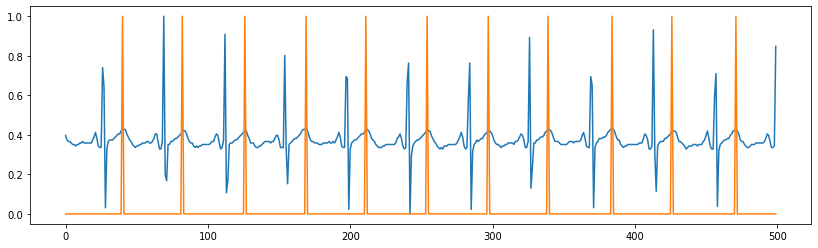

In [5]:
# -------------------------------------------- data loading and pre-processing -------------------------------------------- #

ECG_10sec_list = glob.glob('/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/*ECG2_10sec_set.txt')
ECG_10sec_T_mask_list = glob.glob('/content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/ECG_files/*ECG2_10sec_set_T_mask.txt')

# d = list(zip(ECG_10sec_list, ECG_10sec_T_mask_list))
# shuffle(d)
# ECG_10sec_list, ECG_10sec_T_mask_list = zip(*d)

train_ECG_list = []
train_mask_list = []
val_ECG_list = []
val_mask_list = []

for filenum in range(len(ECG_10sec_list)):
    ECG_data = np.loadtxt(ECG_10sec_list[filenum])
    ECG_mask_data = np.loadtxt(ECG_10sec_T_mask_list[filenum])
    
    if len(ECG_data) != timesteps:
        for datanum in range(len(ECG_data)):
            a = ECG_data[datanum].copy()
            a = a - np.min(a)
            a = a / np.max(a)

            b = ECG_mask_data[datanum].copy()

            if filenum < 0.8 * len(ECG_10sec_list):
                train_ECG_list.append(a)
                train_mask_list.append(b)
            else:
                val_ECG_list.append(a)
                val_mask_list.append(b)
                
# plot the last data
plt.figure(figsize=(14,4))
plt.plot(a)
plt.plot(b)
plt.show()

# conver the lists into arrays
train_ECG = np.asarray(train_ECG_list)
train_mask = np.asarray(train_mask_list)
val_ECG = np.asarray(val_ECG_list)
val_mask = np.asarray(val_mask_list)

# need to reshape the data into 3 dimensions (batch_size, timesteps, channel_number) for Keras convolution 
train_ECG = np.reshape(train_ECG, [len(train_ECG), timesteps, 1])
train_mask = np.reshape(train_mask, [len(train_mask), timesteps, 1])
val_ECG = np.reshape(val_ECG, [len(val_ECG), timesteps, 1])
val_mask = np.reshape(val_mask, [len(val_mask), timesteps, 1])

In [6]:
# ------------------------------------------ deep learning model definition ------------------------------------------ #

def CNN():

    model_inputs = tf.keras.Input(shape=(int(timesteps), 1))
    
    # first conv-batchnorm-maxpool layer
    x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same',input_shape=(int(timesteps), 1))(model_inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    out1 = x
    x = tf.keras.layers.MaxPooling1D(2, 2, padding='same')(x)
    
    # second conv-batchnorm-maxpool layer
    x = tf.keras.layers.Conv1D(filters=4, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    out2 = x
    x = tf.keras.layers.MaxPooling1D(2, 2, padding='same')(x)
    
    # third conv-batchnorm-maxpool layer
    x = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    out3 = x
    x = tf.keras.layers.MaxPooling1D(5, 5, padding='same')(x)
    
    # fourth conv-batchnorm layer
    x = tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # fifth upsample-concat-conv-batchnorm layer
    x = tf.keras.layers.UpSampling1D(5)(x)
    x = tf.keras.layers.Concatenate()([x, out3])
    x = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # sixth upsample-concat-conv-batchnorm layer
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Concatenate()([x, out2])
    x = tf.keras.layers.Conv1D(filters=4, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

        # seventh upsample-concat-conv-batchnorm layer
    x = tf.keras.layers.UpSampling1D(2)(x)
    x = tf.keras.layers.Concatenate()([x, out1])
    x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    # last convolution layer
    out = tf.keras.layers.Conv1D(filters=1, kernel_size=3, activation='sigmoid', padding='same')(x)

    model = tf.keras.Model(inputs=model_inputs, outputs=out)

    return model

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 751/2000
1/1 - 0s - loss: 0.0627 - val_loss: 0.0721

Epoch 00751: val_loss improved from 0.07213 to 0.07207, saving model to /content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/CNN_ECGT_500timesteps_tensorboard/checkpoints
Epoch 752/2000
1/1 - 0s - loss: 0.0626 - val_loss: 0.0720

Epoch 00752: val_loss improved from 0.07207 to 0.07201, saving model to /content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/CNN_ECGT_500timesteps_tensorboard/checkpoints
Epoch 753/2000
1/1 - 0s - loss: 0.0625 - val_loss: 0.0720

Epoch 00753: val_loss improved from 0.07201 to 0.07196, saving model to /content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/CNN_ECGT_500timesteps_tensorboard/checkpoints
Epoch 754/2000
1/1 - 0s - loss: 0.0624 - val_loss: 0.0719

Epoch 00754: val_loss improved from 0.07196 to 0.07190, saving model to /content/gdrive/My Drive/20210828_KOHI_CNN_ECGT-main/CNN_ECGT_500timesteps_tensorboard/checkpoints
Epoch 755/2000
1/1 - 0s - loss: 0.0623 - val

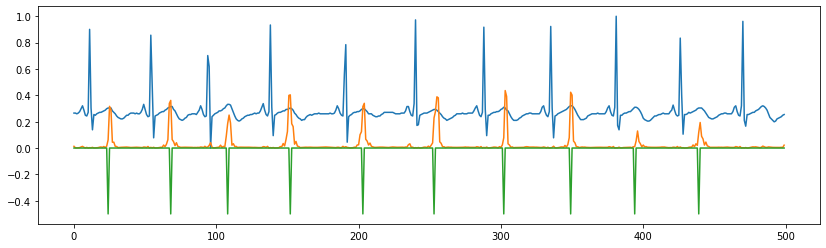

In [8]:
# ----------------------------------- deep learning model training & validation -------------------------------------- #

CNN_UNET = CNN()

CNN_UNET.compile(optimizer='adam', loss='binary_crossentropy')

cp_callback = tf.keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, verbose=1, save_best_only=True, save_weights_only=True, period=1)

CNN_UNET.fit(train_ECG, train_mask, epochs=2000, batch_size=10000, shuffle=True, validation_data=(val_ECG, val_mask), verbose=2, callbacks=[cp_callback])

CNN_UNET.load_weights(CHECKPOINT_PATH)
prediction = CNN_UNET.predict(val_ECG)

val_ECG_save = np.reshape(val_ECG, [-1])
val_mask_save = np.reshape(val_mask, [-1])
prediction_save = np.reshape(prediction, [-1])

name = 'ECG_T_CNN_UNET_timesteps_' + str(int(timesteps)) + '_kernel_size_' + str(int(kernel_size)) + '_prediction_results.txt'
file = open(name, 'w')
for result_num in range(int(len(prediction)/10)):
    file.write("%f %f %f \n" % (val_ECG_save[result_num], prediction_save[result_num], val_mask_save[result_num]))
file.close()

plt.figure(figsize=(14,4))
plt.plot(val_ECG_save[:timesteps])
plt.plot(prediction_save[:timesteps])
plt.plot(val_mask_save[:timesteps]*-0.5)
plt.show()